In [65]:
from cgmtools import utils
from cgmtools import plotting
import datetime
import numpy as np
import pandas as pd
import pickle as pkl
from seaborn import plt
%matplotlib inline

# Artifact detection
simple approach:
1. load cgm profile
2. compute first derivative
3. exclude patients with first derivative larger than a threshold

In [16]:
# Load full data set from pickle file (see data_wrangler.py)
dfs_full = pkl.load(open('../../data/dfs_py3.pkl', 'rb'))

# Keep only patients with more than `THRESHOLD` days of CGM acquisition
_threshold = datetime.timedelta(days=3.5)  # default
dfs = utils.filter_patients(dfs_full, _threshold)

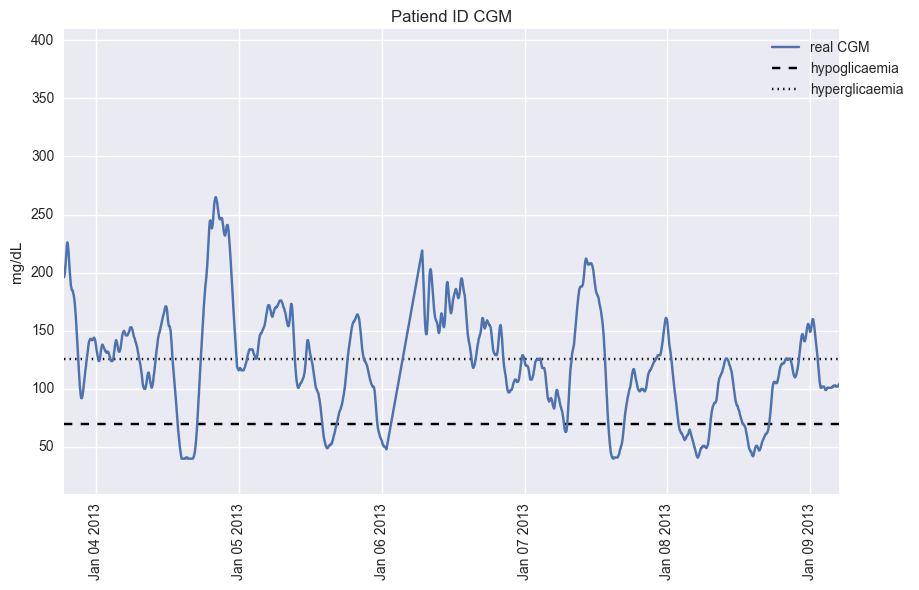

In [121]:
# Get patients list
patients = list(dfs.keys())
k = 45
#idx = patients[k]
#idx = 'Bernasconi Roberta 2.csv'
idx = 'Avanzini Francesco.csv'
#idx = 'Arras Matilde.csv'
#idx = 'Buganè Jessica 2.csv'
df = utils.gluco_extract(dfs[idx], return_df=True)
plotting.cgm(df)

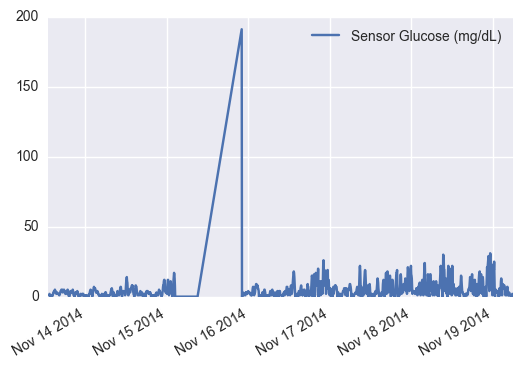

In [161]:
df1 = df.diff().abs()
df1.plot()

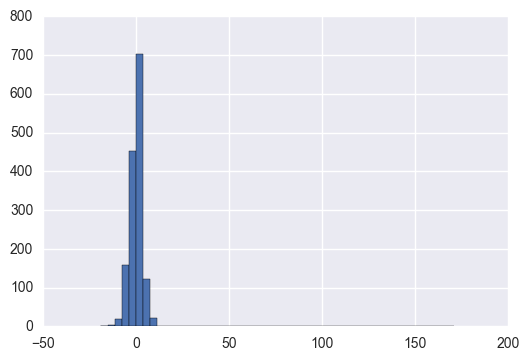

In [115]:
plt.hist(df1.values.ravel()[1:], bins=50);

In [156]:
threshold = 50 # not more than 50 mg/dl is allowed
artifacted = []
for idx in patients:
    df = utils.gluco_extract(dfs[idx], return_df=True)
    dmax = df.diff().abs().max()

    if dmax.values > threshold:
        artifacted.append(idx)

/Users/samu/miniconda2/envs/cgm-tools/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


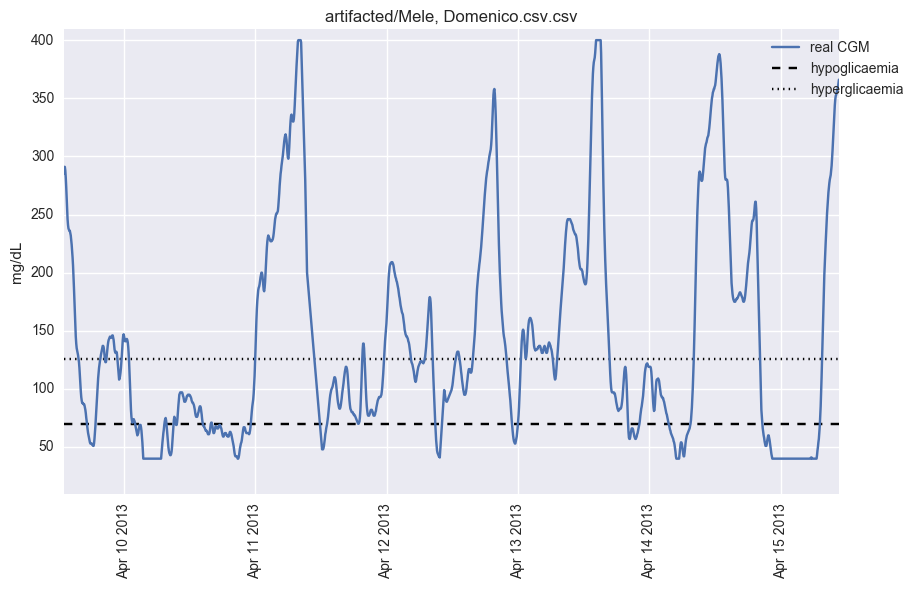

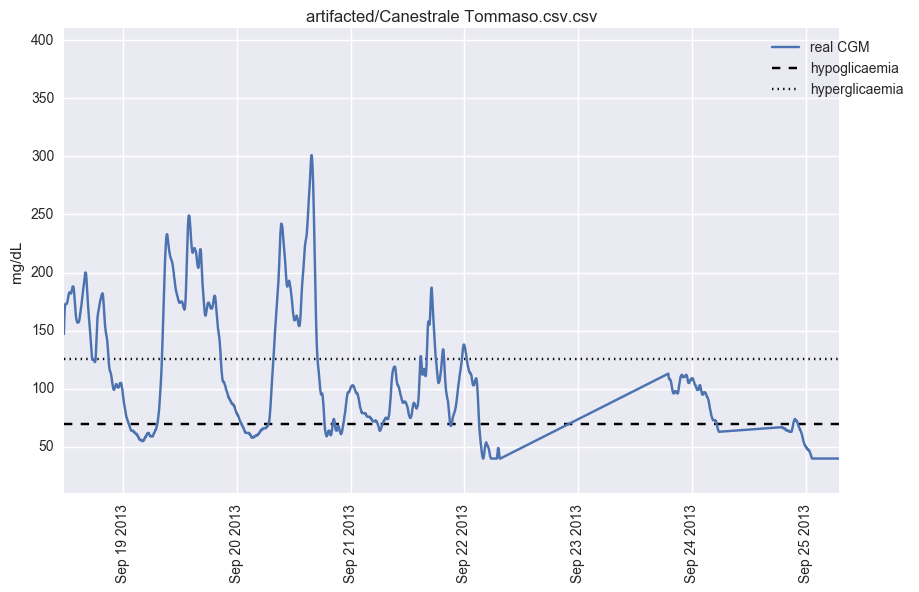

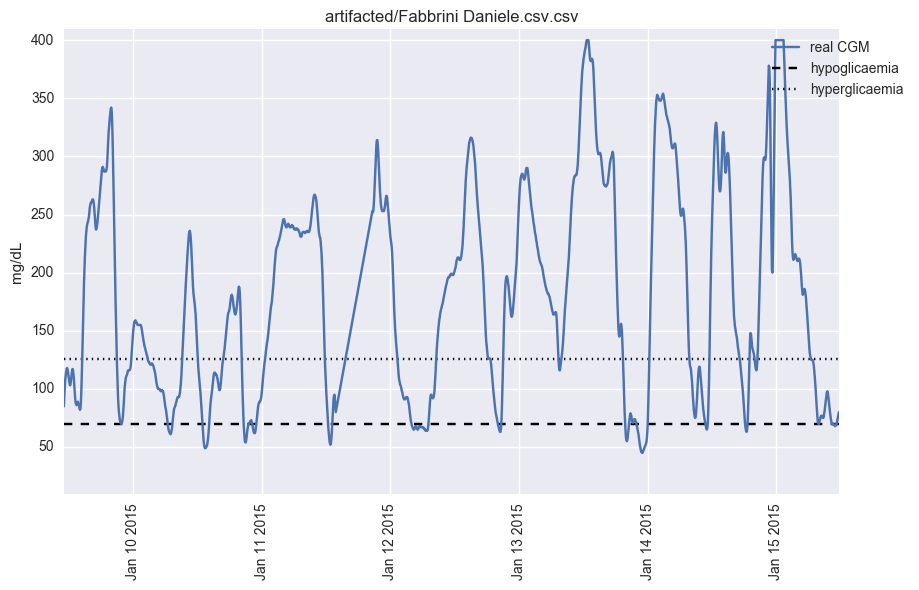

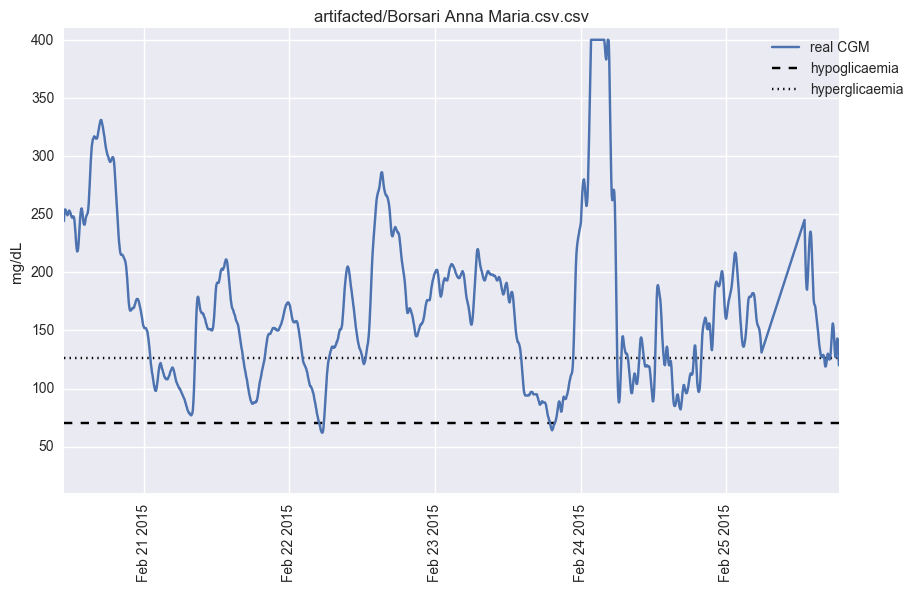

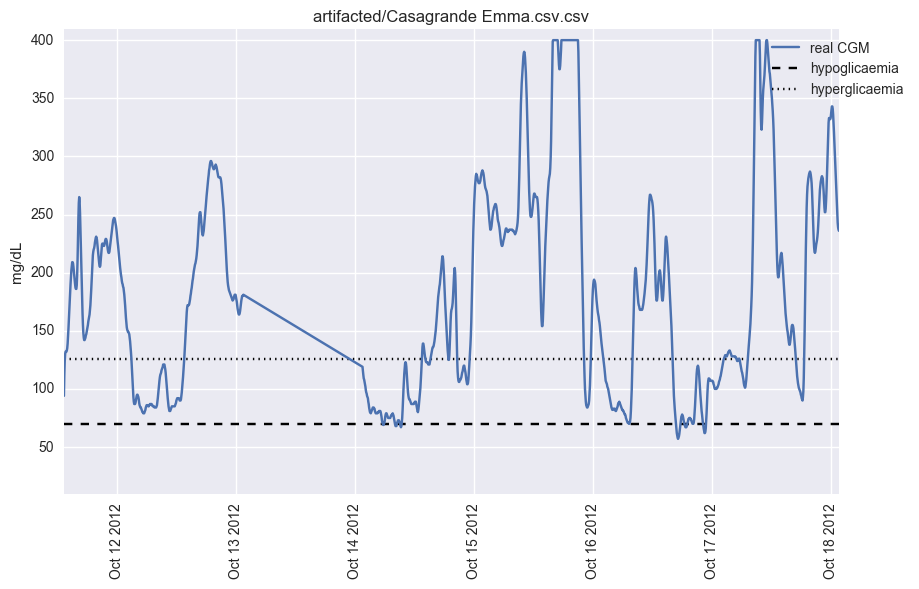

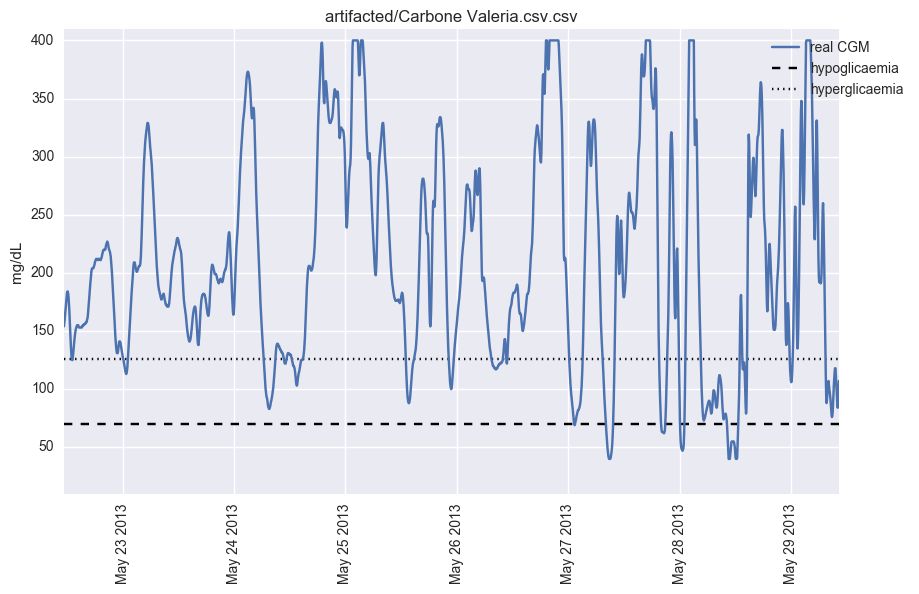

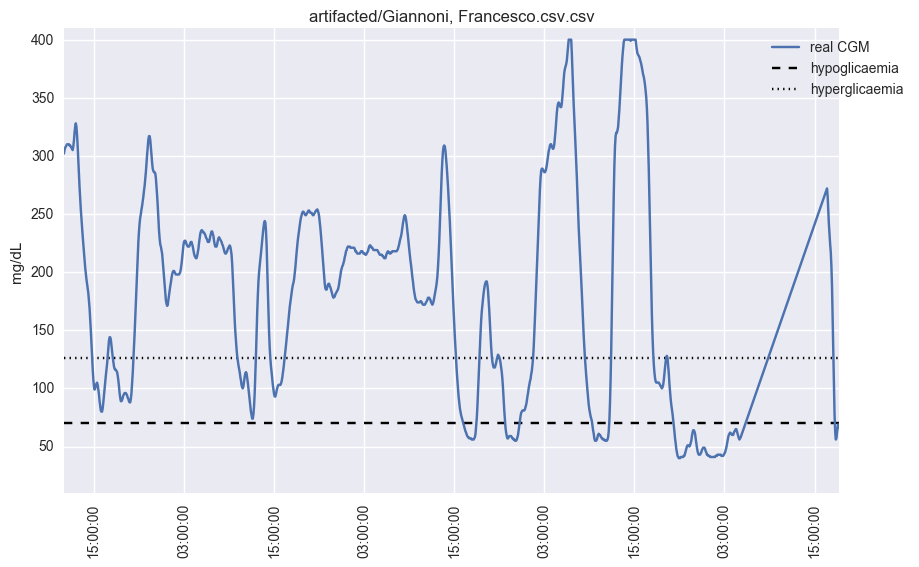

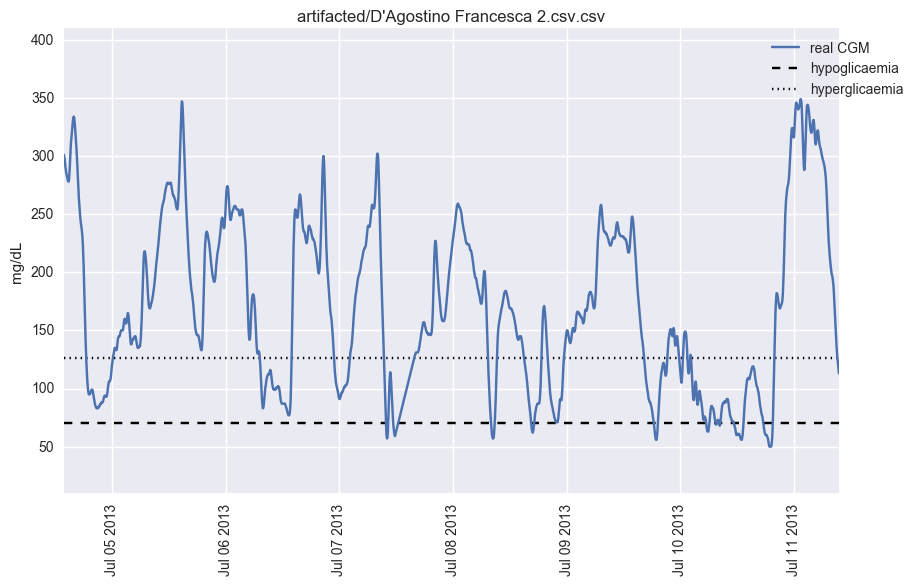

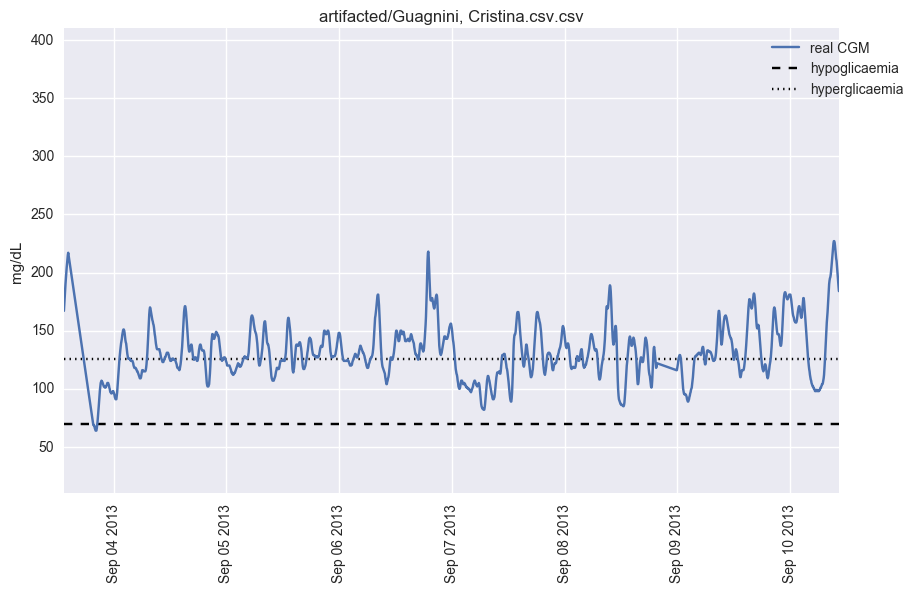

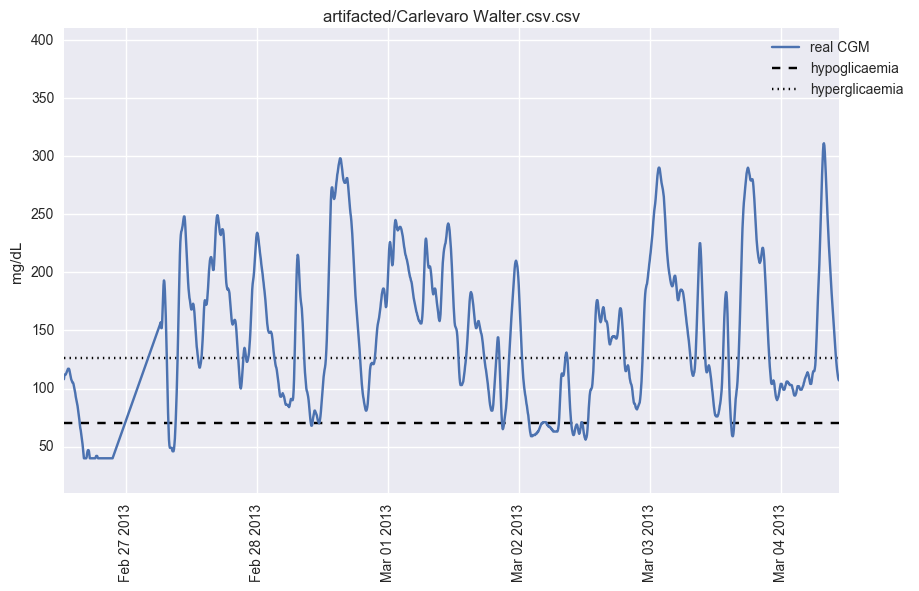

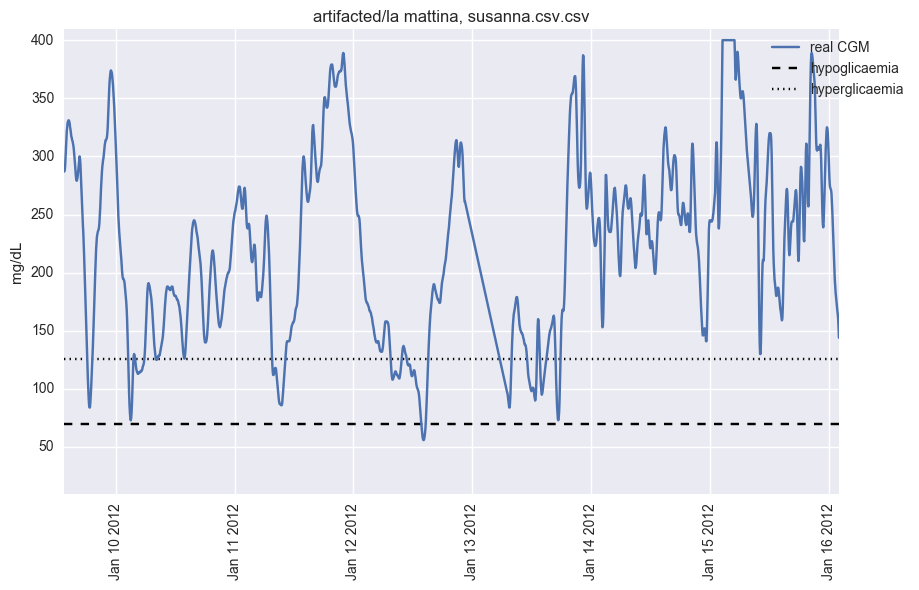

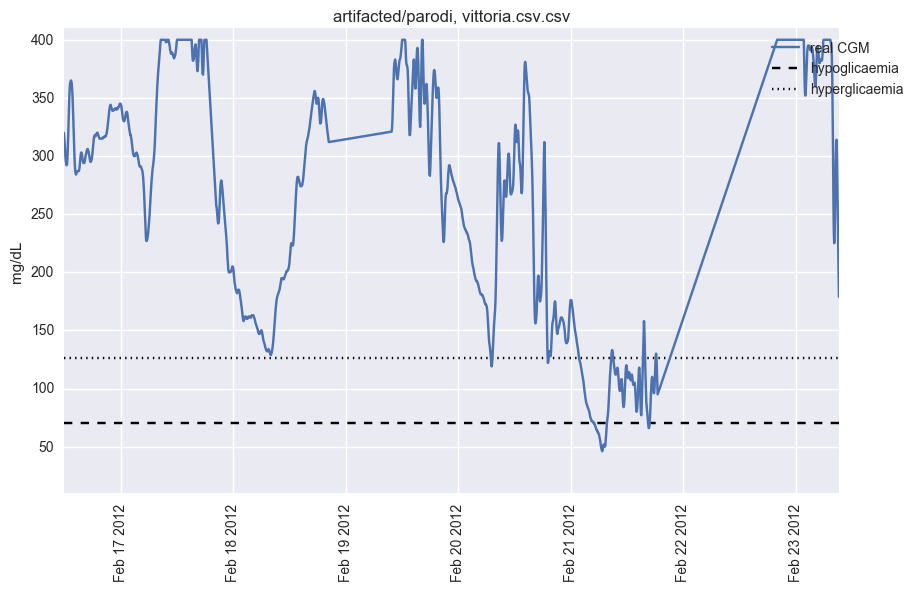

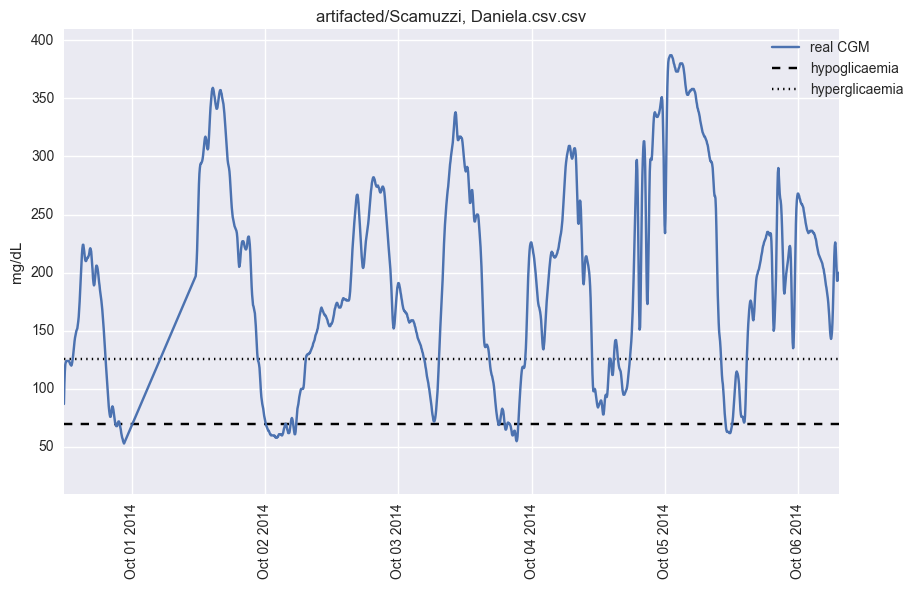

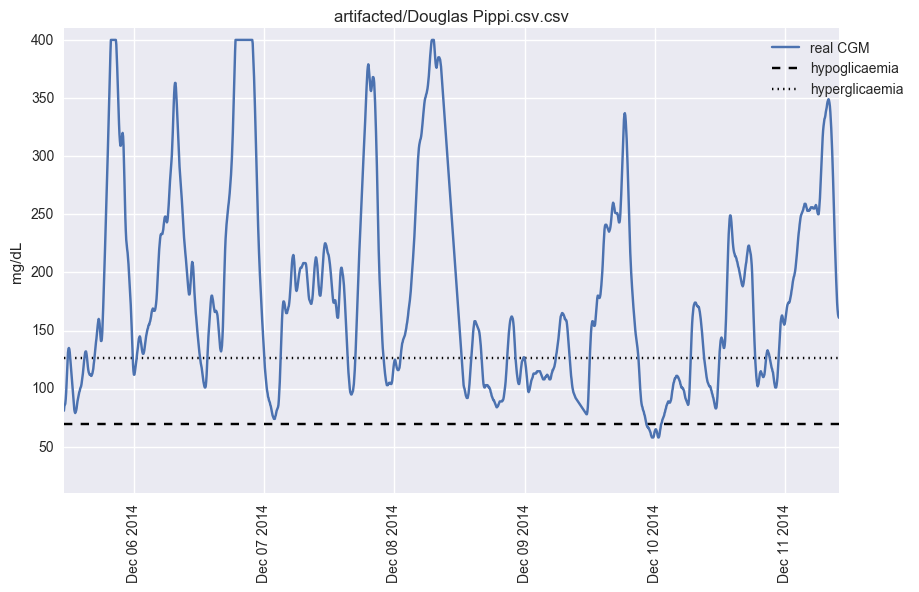

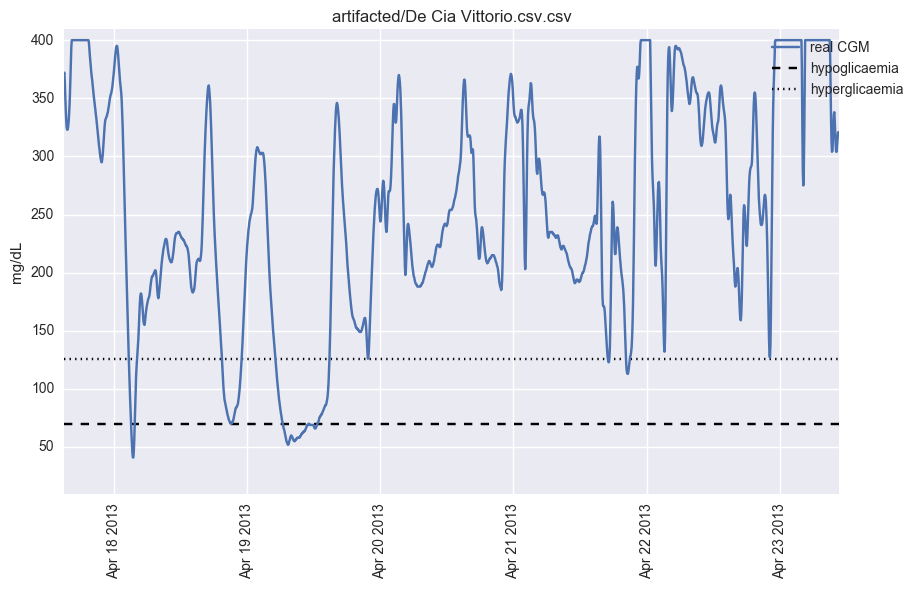

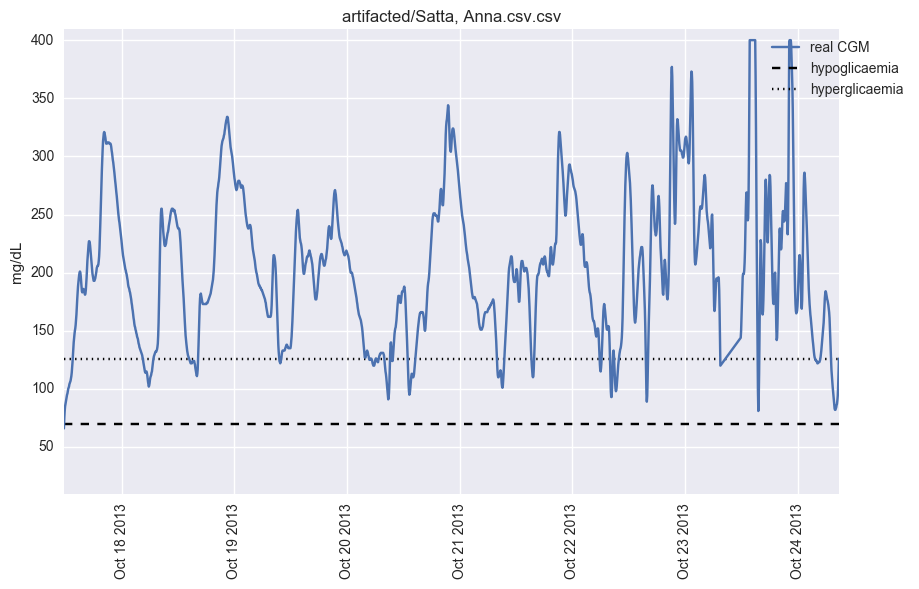

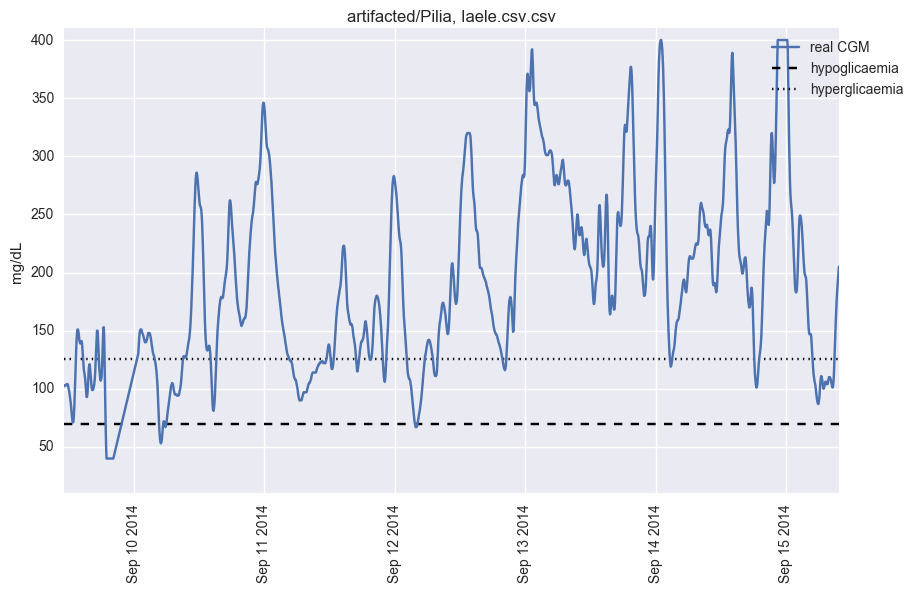

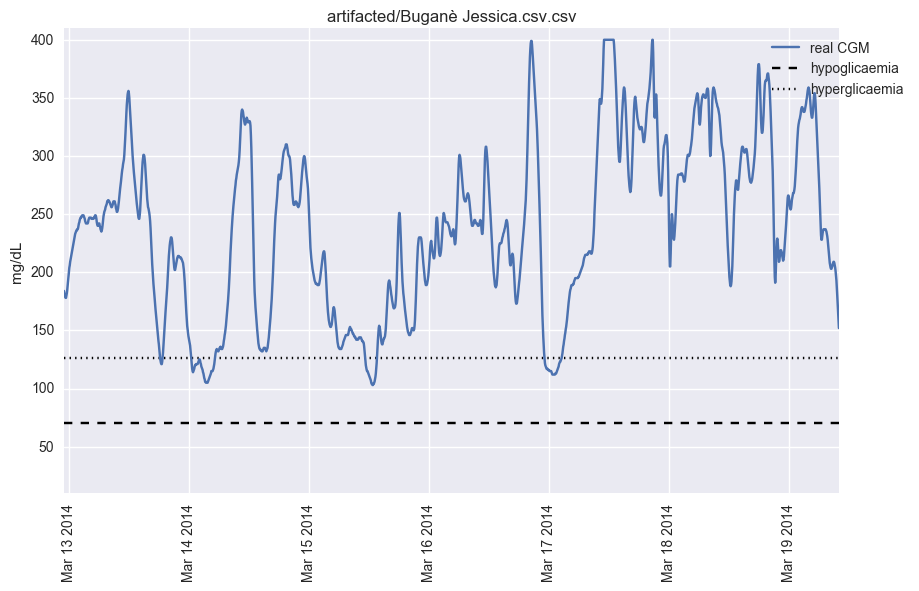

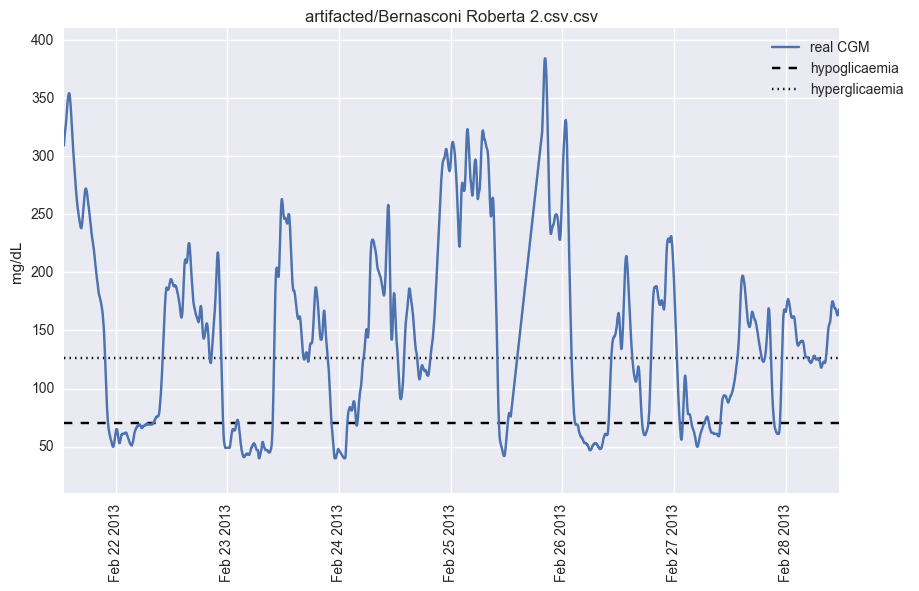

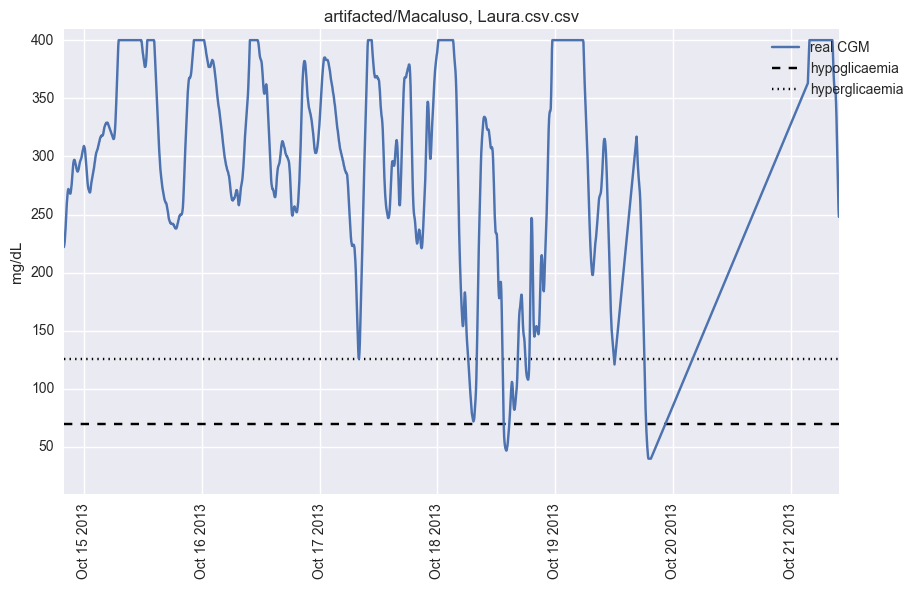

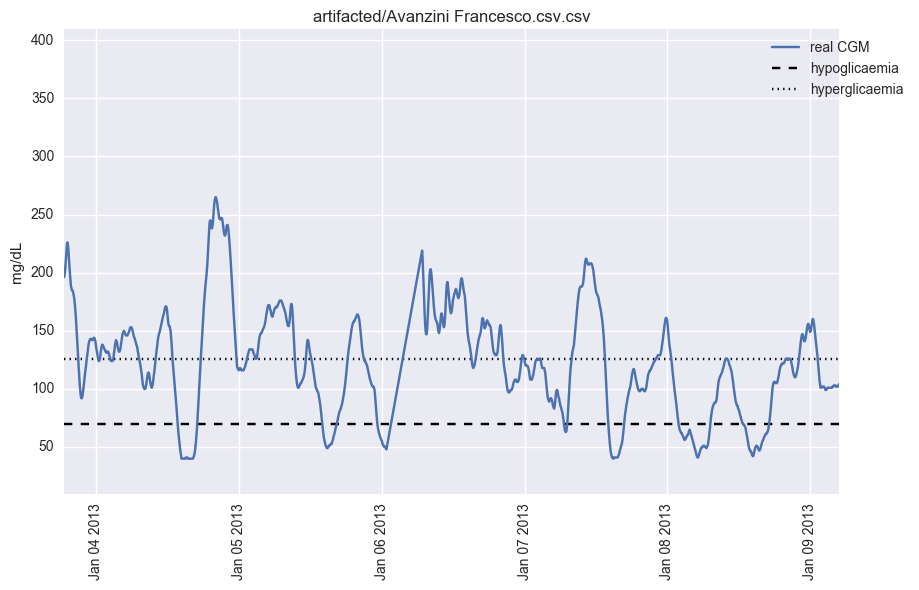

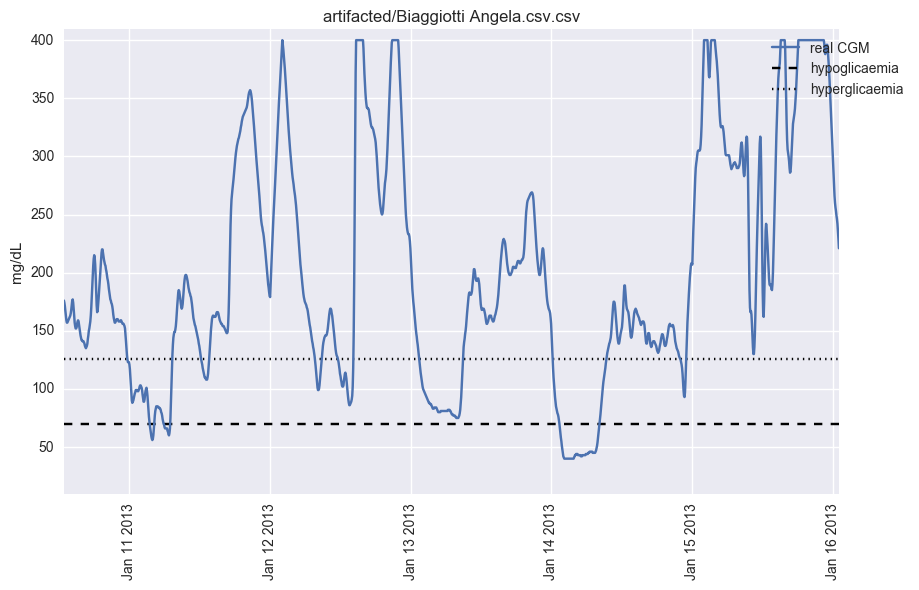

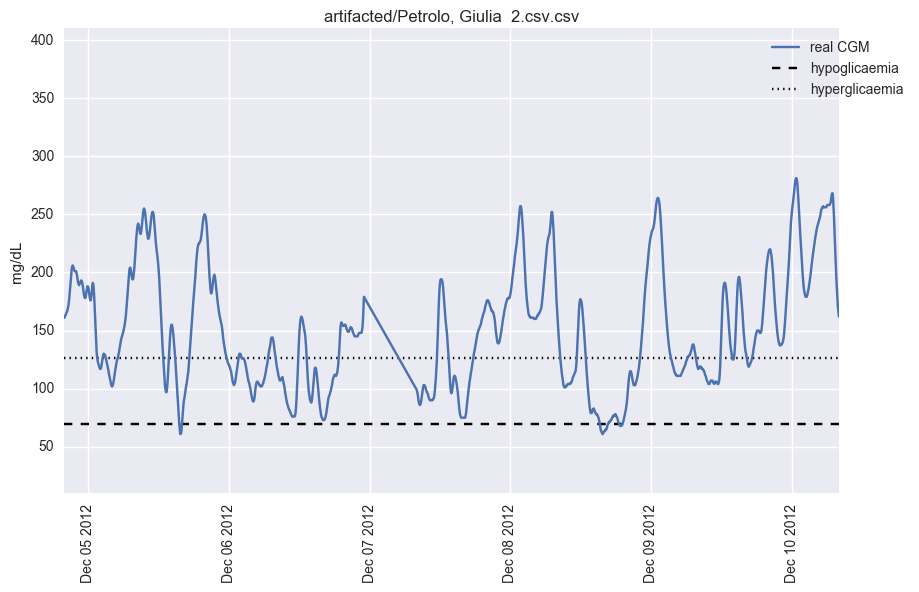

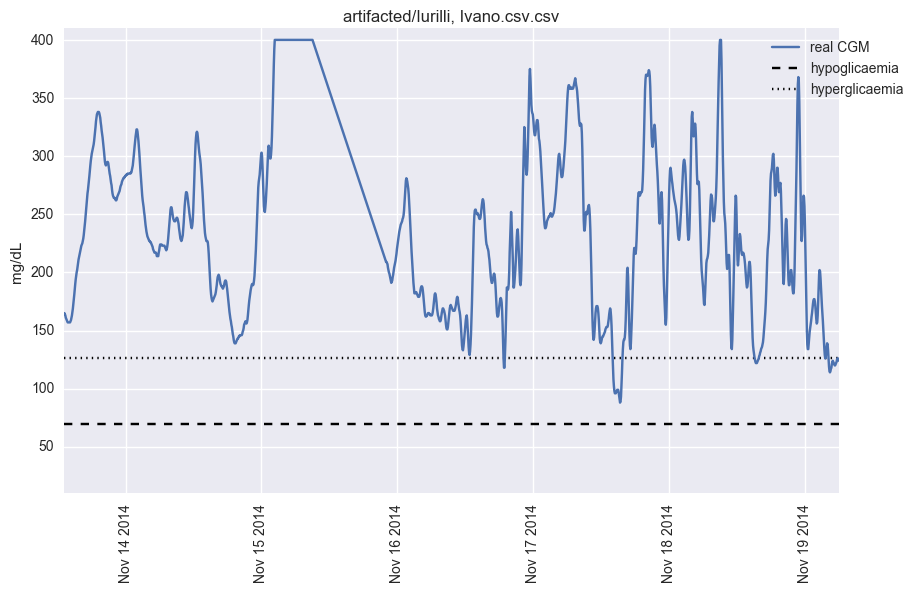

In [157]:
for idx in artifacted:
    df = utils.gluco_extract(dfs[idx], return_df=True)
    plotting.cgm(df, savefig=True, title='artifacted/'+idx+'.csv')

In [158]:
print("{} patients exluded, now they are {}".format(len(artifacted), len(patients)-len(artifacted)))
print(artifacted, file=open('artifacted/artifacted_list.txt', 'w'))

24 patients exluded, now they are 136


# Build LSTM training set

split into 70% test and 30% train (i.e. 40 training patients)

In [188]:
from cgmtools.forecast import lstm
from sklearn.preprocessing import MinMaxScaler

In [186]:
# Filter artifacted patients
filtered_patients = list(filter(lambda x: x not in artifacted, patients))

#Training / Test set split
test_set_ratio = 0.7
indexes = np.arange(len(filtered_patients))
np.random.shuffle(indexes)
training_idx = indexes[:int((1 - test_set_ratio) * len(filtered_patients))]
training_patients = np.array(filtered_patients)[training_idx]

In [206]:
w_size = 36 
X_tr = []
Y_tr = []
for idx in training_patients:
    df = utils.gluco_extract(dfs[idx], return_df=True)
    train_data_i = MinMaxScaler(feature_range=(0, 1)).fit_transform(df)
    
    X_tr_i, Y_tr_i = lstm.create_XY_dataset(train_data_i, window_size=w_size)
    X_tr.append(X_tr_i)
    Y_tr.append(Y_tr_i)
X_tr = np.vstack(X_tr)
Y_tr = np.hstack(Y_tr)

In [212]:
print("Training data shape: {}".format(X_tr.shape))
print("Training labels shape: {}".format(Y_tr.shape))

Training data shape: (68114, 36, 1)
Training labels shape: (68114,)


In [208]:
pkl.dump({'X_tr': X_tr, 'Y_tr': Y_tr}, open('XY_training.pkl', 'wb'))

In [210]:
ls -lh

total 49248
-rw-r--r--@  1 samu  staff   911K Jan 20 10:40 LSTM_cv.ipynb
-rw-r--r--@  1 samu  staff   841K Jan 20 10:18 LSTM_debugging.ipynb
-rw-r--r--@  1 samu  staff    19M Jan 22 14:09 XY_training.pkl
-rw-r--r--@  1 samu  staff   2.4M Jan 22 14:09 artifact_detection_LSTM_modell1.ipynb
drwxr-xr-x@ 28 samu  staff   952B Jan 22 11:49 artifacted/
-rw-r--r--@  1 samu  staff   372K Jan 16 10:45 gluco_predictions.ipynb
-rw-r--r--@  1 samu  staff   358K Jan 17 12:31 gluco_predictions_Kalman.ipynb
